#### Andrew Taylor
#### EN 705.601
#### Applied Machine Learning
## Homework 3 - Resubmitted with Python

### Predicting Suicide Probabilities from the "Suicide Rates Overview 1985 to 2016" Data Set

#### Question 1: Objectives

Suicide is a very real phenomenon, and anything that can be done to prevent it is worthwhile. If there was a way to predict suicide, or establish a probability for suicide from some factors under study, the resulting information could be used for intervention or social planning. Assuming there are definite factors which lead to suicide, the event can be modeled and predicted with a machine learning model. It can be learned, and that will be the objective of this notebook. 

#### Question 2: The Problem

What can be classified or predicted with this dataset? It consists of 27,820 observations, with 12 features: country, year, sex, age, number of suicides, population, suicides per 100k population, country and year concatenated, Human Development Index, GDP for the observation year, GDP per capita, and the generation of the cohort recorded. Because the groups delineated by the observations are at the country/year/sex/age group level, our classification or prediction would be about groups so defined. A regression could be carried out to predict either the total number of suicides or the suicide rates (per 100k). One-hot encoding would be used for categorical variables, and after a train-test split, we could train a regression model and evaluate the performance on the testing set using metrics such as Mean Absolute Error, Mean Squared Error and R-Squared. Because we cover regression in a later module, for this exercise I will focus on classification. 

What can classification of the data set show? We can create categories/levels of suicide rates, such as low, medium, and high, then predict which category a particular group falls into (country/year/sex/age groups). Another classification task we will try is to predict the generation most at risk in a given year based on other features. This notebook will attempt these two tasks. These are the formulations of our problems under study. 

Let's also note that an unsupervised approach could yield insights. For instance, clustering countries based on features like GDP, GDP per capita, and suicide rates might reveal groups of countries with similar economic and mental health profiles. We could also use unsupervised methods to create new features which might be useful for other tasks.

#### Question 3: The Dependent Variable

We are going to do two classifications. For the first, suicide rates, we will transform the continuous variable 'suicides per 100k pop' into a categorical variable to serve as our dependent variable. This will have three levels, low, medium, and high suicide rate. This will let us look at which features indicate which groups most at risk.

For our second study, the dependent variable will be the 'generation' feature. The task would be predicting the generation most at risk in a given year based on other features. These are our dependent/target variables and the other features would represent independent variables for prediction.

#### Question 4: Correlations and Variable Ranking

Using Weka, it is easy to run a preliminary correlation matrix and see the correlation between the features and the dependent variables. For suicide rate, we already have a continuous variable, so we only need to define the bins for the levels of risk. However, for the generation question we need to one-hot encode. Let's look at suicide rates first:

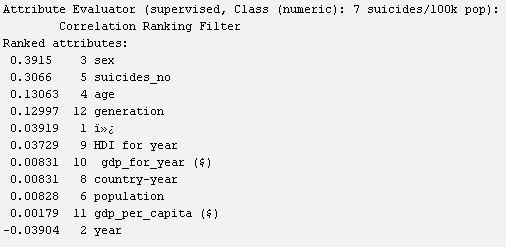

Looking at the results above, we can see the top 5 features that correlated to the target variable are sex, total suicides for the group, age, generation and country. The *i>?* feature is actually country, for some reason Weka isn't displaying the column header correctly. Also, total suicides is a somewhat redundant feature, so the main features that display information we can use are sex, age (a proxy for generation), and country. HDI, the Human Development Index comes in close after country, and this would make sense because HDI is "is a statistical composite index of life expectancy, education (mean years of schooling completed and expected years of schooling upon entering the education system), and per capita income indicators, which is used to rank countries into four tiers of human development.", per Wikipedia. So, we will focus on HDI too. To get the true numbers, let's drop the other features and re-run the correlation matrix:

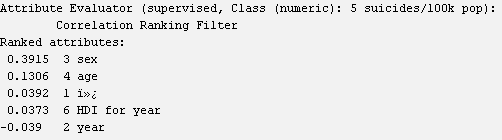

Unfortunately Weka did not recalculate the correlations based on the reduced features, and I don't know why. But, eyeballing the proportions of the correlations reported we can see that sex is about 10 times more correlated with suicide rate than country, and 3 times as correlated as age. HDI rounds out the group and the year of the observation does not seem to matter.

For the generational risk question, I dropped all features except suicide rate and total suicides, because that's what we are trying to understand. It doesn't help us to know if the country is correlated with the generation, for example. After discretizing the suicide rate into low, medium and high, we see this matrix:

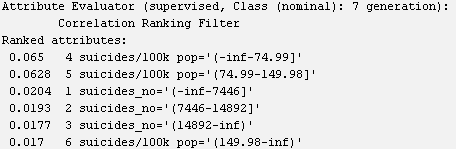

Once again Weka doesn't seem to be dropping features correctly, but from the numbers that low and medium rates of suicide are most highly correlated to the generation. We'll see more when we run a classification.

#### Question 5: Pre-processing

From this exploration, and some common sense, we can remove some features and perform Sequential Backwards Selection on the features that matter most for both questions. Since the data set comes from Kaggle it is generally well-formed without blanks and missing values to impute. The major features to use for each question are:

*Predicting Suicide Rates*
1) age
2) sex
3) Country

*Predicting Generational Risk*
1) suicide rate per 100k

The other features are either derived features, or exhibit low correlation with the target variable. In the case of generational risk, the other features are irrelevant.


To preprocess this dataset for machine learning classification with SVM and Random Forest, we'll follow these steps:

1) Handle missing values.
2) One-hot encode nominal variables (including 'age').
3) Normalize numerical features.
4) Convert 'gdp_for_year ($)' to a proper numerical format.



In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Step 0: Load the data
file_path = 'master.csv'  # Replace with the actual path to the dataset
data = pd.read_csv(file_path)

# Clean column names by removing extra quotes and trimming spaces
data.columns = data.columns.str.strip("' ").str.replace("'", "")

# Step 1: Handle missing values
# Identify columns with missing values and impute them
num_imputer = SimpleImputer(strategy='mean')
nom_imputer = SimpleImputer(strategy='most_frequent')

# Identify numerical and nominal columns
num_cols = ['year', 'suicides_no', 'population', 'suicides/100k pop', 'HDI for year', 'gdp_per_capita ($)']
nom_cols = ['country', 'sex', 'age', 'country-year', 'generation']

# Create separate imputers for numerical and nominal columns
imputers = ColumnTransformer(
    transformers=[
        ('num', num_imputer, num_cols),
        ('nom', nom_imputer, nom_cols)])

# Apply imputers
data_imputed = pd.DataFrame(imputers.fit_transform(data), columns=num_cols+nom_cols)
data_imputed[num_cols] = data_imputed[num_cols].apply(pd.to_numeric)

# Step 2: One-hot encode nominal variables
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')

# Step 3: Normalize numerical features
scaler = StandardScaler()

# Step 4: Convert 'gdp_for_year ($)' to a proper numerical format
data_imputed['gdp_for_year ($)'] = data['gdp_for_year ($)'].str.replace(',', '').astype(float)
num_cols.append('gdp_for_year ($)')

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('nom', one_hot_encoder, nom_cols)
    ])

# Apply the preprocessing pipeline to the data
data_preprocessed = preprocessor.fit_transform(data_imputed)

# Retrieve feature names for one-hot encoded columns
one_hot_feature_names = preprocessor.named_transformers_['nom'].get_feature_names_out(input_features=nom_cols)

# Combine all feature names
all_feature_names = num_cols + one_hot_feature_names.tolist()

# Convert the preprocessed data back to a DataFrame for better readability
data_preprocessed_df = pd.DataFrame(data_preprocessed, columns=all_feature_names)

for column in data_preprocessed_df.columns:
    print(column)

year
suicides_no
population
suicides/100k pop
HDI for year
gdp_per_capita ($)
gdp_for_year ($)
country_Antigua and Barbuda
country_Argentina
country_Armenia
country_Aruba
country_Australia
country_Austria
country_Azerbaijan
country_Bahamas
country_Bahrain
country_Barbados
country_Belarus
country_Belgium
country_Belize
country_Bosnia and Herzegovina
country_Brazil
country_Bulgaria
country_Cabo Verde
country_Canada
country_Chile
country_Colombia
country_Costa Rica
country_Croatia
country_Cuba
country_Cyprus
country_Czech Republic
country_Denmark
country_Dominica
country_Ecuador
country_El Salvador
country_Estonia
country_Fiji
country_Finland
country_France
country_Georgia
country_Germany
country_Greece
country_Grenada
country_Guatemala
country_Guyana
country_Hungary
country_Iceland
country_Ireland
country_Israel
country_Italy
country_Jamaica
country_Japan
country_Kazakhstan
country_Kiribati
country_Kuwait
country_Kyrgyzstan
country_Latvia
country_Lithuania
country_Luxembourg
country_Maca

country-year_Jamaica2004
country-year_Jamaica2005
country-year_Jamaica2006
country-year_Jamaica2009
country-year_Jamaica2010
country-year_Jamaica2011
country-year_Japan1985
country-year_Japan1986
country-year_Japan1987
country-year_Japan1988
country-year_Japan1989
country-year_Japan1990
country-year_Japan1991
country-year_Japan1992
country-year_Japan1993
country-year_Japan1994
country-year_Japan1995
country-year_Japan1996
country-year_Japan1997
country-year_Japan1998
country-year_Japan1999
country-year_Japan2000
country-year_Japan2001
country-year_Japan2002
country-year_Japan2003
country-year_Japan2004
country-year_Japan2005
country-year_Japan2006
country-year_Japan2007
country-year_Japan2008
country-year_Japan2009
country-year_Japan2010
country-year_Japan2011
country-year_Japan2012
country-year_Japan2013
country-year_Japan2014
country-year_Japan2015
country-year_Kazakhstan1990
country-year_Kazakhstan1991
country-year_Kazakhstan1992
country-year_Kazakhstan1993
country-year_Kazakhstan19

country-year_Poland2010
country-year_Poland2011
country-year_Poland2012
country-year_Poland2013
country-year_Poland2014
country-year_Poland2015
country-year_Portugal1985
country-year_Portugal1986
country-year_Portugal1987
country-year_Portugal1988
country-year_Portugal1989
country-year_Portugal1990
country-year_Portugal1991
country-year_Portugal1992
country-year_Portugal1993
country-year_Portugal1994
country-year_Portugal1995
country-year_Portugal1996
country-year_Portugal1997
country-year_Portugal1998
country-year_Portugal1999
country-year_Portugal2000
country-year_Portugal2001
country-year_Portugal2002
country-year_Portugal2003
country-year_Portugal2007
country-year_Portugal2008
country-year_Portugal2009
country-year_Portugal2010
country-year_Portugal2011
country-year_Portugal2012
country-year_Portugal2013
country-year_Portugal2014
country-year_Puerto Rico1985
country-year_Puerto Rico1986
country-year_Puerto Rico1987
country-year_Puerto Rico1988
country-year_Puerto Rico1989
country-y

country-year_Ukraine1996
country-year_Ukraine1997
country-year_Ukraine1998
country-year_Ukraine1999
country-year_Ukraine2000
country-year_Ukraine2001
country-year_Ukraine2002
country-year_Ukraine2003
country-year_Ukraine2004
country-year_Ukraine2005
country-year_Ukraine2006
country-year_Ukraine2007
country-year_Ukraine2008
country-year_Ukraine2009
country-year_Ukraine2010
country-year_Ukraine2011
country-year_Ukraine2012
country-year_Ukraine2014
country-year_Ukraine2015
country-year_United Arab Emirates2005
country-year_United Arab Emirates2006
country-year_United Arab Emirates2007
country-year_United Arab Emirates2008
country-year_United Arab Emirates2009
country-year_United Arab Emirates2010
country-year_United Kingdom1985
country-year_United Kingdom1986
country-year_United Kingdom1987
country-year_United Kingdom1988
country-year_United Kingdom1989
country-year_United Kingdom1990
country-year_United Kingdom1991
country-year_United Kingdom1992
country-year_United Kingdom1993
country-y

In [24]:
# Function to categorize suicide rates
def categorize_suicide_rate(rate):
    if rate <= 10:
        return 'Low'
    elif 10 < rate <= 20:
        return 'Medium'
    else:
        return 'High'

# Add 'Risk Category' to data_imputed based on 'suicides/100k pop'
data_imputed['Risk Category'] = data_imputed['suicides/100k pop'].apply(categorize_suicide_rate)


# Check if 'Risk Category' exists in data_imputed
'Risk Category' in data_imputed.columns


True

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Importing SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Importing evaluation metrics

# Add risk category to the preprocessed dataset
# Try adding the 'Risk Category' column to data_preprocessed_df 
try:
    data_preprocessed_df['Risk Category'] = data_imputed['Risk Category'].values
    operation_status = "Successfully added 'Risk Category' to data_preprocessed_df."
except Exception as e:
    operation_status = f"An error occurred: {e}"

operation_status


data_preprocessed_df['Risk Category'] = data_imputed['Risk Category']

# Step 3: Feature Selection (Updated)
# Since the features are already one-hot encoded and normalized, we just need to select them from data_preprocessed_df
# Identify the selected feature columns from the preprocessed DataFrame
selected_features_svm = [col for col in data_preprocessed_df.columns if col in all_feature_names]
X_svm = data_preprocessed_df[selected_features_svm]
y_svm = data_preprocessed_df['Risk Category']

# To display the full list of column names without truncation
# Loop through and print each column name
for column in X_svm.columns:
    print(column)


year
suicides_no
population
suicides/100k pop
HDI for year
gdp_per_capita ($)
gdp_for_year ($)
country_Antigua and Barbuda
country_Argentina
country_Armenia
country_Aruba
country_Australia
country_Austria
country_Azerbaijan
country_Bahamas
country_Bahrain
country_Barbados
country_Belarus
country_Belgium
country_Belize
country_Bosnia and Herzegovina
country_Brazil
country_Bulgaria
country_Cabo Verde
country_Canada
country_Chile
country_Colombia
country_Costa Rica
country_Croatia
country_Cuba
country_Cyprus
country_Czech Republic
country_Denmark
country_Dominica
country_Ecuador
country_El Salvador
country_Estonia
country_Fiji
country_Finland
country_France
country_Georgia
country_Germany
country_Greece
country_Grenada
country_Guatemala
country_Guyana
country_Hungary
country_Iceland
country_Ireland
country_Israel
country_Italy
country_Jamaica
country_Japan
country_Kazakhstan
country_Kiribati
country_Kuwait
country_Kyrgyzstan
country_Latvia
country_Lithuania
country_Luxembourg
country_Maca

country-year_Japan2005
country-year_Japan2006
country-year_Japan2007
country-year_Japan2008
country-year_Japan2009
country-year_Japan2010
country-year_Japan2011
country-year_Japan2012
country-year_Japan2013
country-year_Japan2014
country-year_Japan2015
country-year_Kazakhstan1990
country-year_Kazakhstan1991
country-year_Kazakhstan1992
country-year_Kazakhstan1993
country-year_Kazakhstan1994
country-year_Kazakhstan1995
country-year_Kazakhstan1996
country-year_Kazakhstan1997
country-year_Kazakhstan1998
country-year_Kazakhstan1999
country-year_Kazakhstan2000
country-year_Kazakhstan2001
country-year_Kazakhstan2002
country-year_Kazakhstan2003
country-year_Kazakhstan2004
country-year_Kazakhstan2005
country-year_Kazakhstan2006
country-year_Kazakhstan2007
country-year_Kazakhstan2008
country-year_Kazakhstan2009
country-year_Kazakhstan2010
country-year_Kazakhstan2011
country-year_Kazakhstan2012
country-year_Kazakhstan2013
country-year_Kazakhstan2014
country-year_Kazakhstan2015
country-year_Kiriba

country-year_Russian Federation2012
country-year_Russian Federation2013
country-year_Russian Federation2014
country-year_Russian Federation2015
country-year_Saint Kitts and Nevis1990
country-year_Saint Kitts and Nevis1991
country-year_Saint Kitts and Nevis1992
country-year_Saint Lucia1986
country-year_Saint Lucia1987
country-year_Saint Lucia1988
country-year_Saint Lucia1989
country-year_Saint Lucia1990
country-year_Saint Lucia1991
country-year_Saint Lucia1992
country-year_Saint Lucia1993
country-year_Saint Lucia1994
country-year_Saint Lucia1995
country-year_Saint Lucia1996
country-year_Saint Lucia1997
country-year_Saint Lucia1998
country-year_Saint Lucia1999
country-year_Saint Lucia2000
country-year_Saint Lucia2001
country-year_Saint Lucia2002
country-year_Saint Lucia2003
country-year_Saint Lucia2004
country-year_Saint Lucia2005
country-year_Saint Lucia2006
country-year_Saint Lucia2008
country-year_Saint Lucia2009
country-year_Saint Lucia2010
country-year_Saint Lucia2011
country-year_S

In [30]:
# Generate a list of columns to keep in X_svm
columns_to_keep = [ 
    'country_Antigua and Barbuda', 'country_Argentina', 'country_Armenia', 'country_Aruba', 
    'country_Australia', 'country_Austria', 'country_Azerbaijan', 'country_Bahamas', 'country_Bahrain',
    'country_Barbados', 'country_Belarus', 'country_Belgium', 'country_Belize', 'country_Bosnia and Herzegovina',
    'country_Brazil', 'country_Bulgaria', 'country_Cabo Verde', 'country_Canada', 'country_Chile',
    'country_Colombia', 'country_Costa Rica', 'country_Croatia', 'country_Cuba', 'country_Cyprus',
    'country_Czech Republic', 'country_Denmark', 'country_Dominica', 'country_Ecuador', 'country_El Salvador',
    'country_Estonia', 'country_Fiji', 'country_Finland', 'country_France', 'country_Georgia',
    'country_Germany', 'country_Greece', 'country_Grenada', 'country_Guatemala', 'country_Guyana',
    'country_Hungary', 'country_Iceland', 'country_Ireland', 'country_Israel', 'country_Italy',
    'country_Jamaica', 'country_Japan', 'country_Kazakhstan', 'country_Kiribati', 'country_Kuwait',
    'country_Kyrgyzstan', 'country_Latvia', 'country_Lithuania', 'country_Luxembourg', 'country_Macau',
    'country_Maldives', 'country_Malta', 'country_Mauritius', 'country_Mexico', 'country_Mongolia',
    'country_Montenegro', 'country_Netherlands', 'country_New Zealand', 'country_Nicaragua', 'country_Norway',
    'country_Oman', 'country_Panama', 'country_Paraguay', 'country_Philippines', 'country_Poland',
    'country_Portugal', 'country_Puerto Rico', 'country_Qatar', 'country_Republic of Korea', 'country_Romania',
    'country_Russian Federation', 'country_Saint Kitts and Nevis', 'country_Saint Lucia', 'country_Saint Vincent and Grenadines',
    'country_San Marino', 'country_Serbia', 'country_Seychelles', 'country_Singapore', 'country_Slovakia',
    'country_Slovenia', 'country_South Africa', 'country_Spain', 'country_Sri Lanka', 'country_Suriname',
    'country_Sweden', 'country_Switzerland', 'country_Thailand', 'country_Trinidad and Tobago', 'country_Turkey',
    'country_Turkmenistan', 'country_Ukraine', 'country_United Arab Emirates', 'country_United Kingdom',
    'country_United States', 'country_Uruguay', 'country_Uzbekistan', 'sex_male',
    'age_25-34 years', 'age_35-54 years', 'age_5-14 years', 'age_55-74 years', 'age_75+ years'
]

# Code to drop all other columns from X_svm, leaving only the specified columns
X_svm = X_svm[columns_to_keep]



In [32]:

# Separate 'HDI for year' from the rest of the columns for one-hot encoding
columns_to_encode = [col for col in columns_to_keep if col != 'HDI for year']

# Perform one-hot encoding on the selected columns
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
one_hot_encoded = one_hot_encoder.fit_transform(X_svm[columns_to_encode])

# Create DataFrame for one-hot encoded columns and give them identifiable names
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(columns_to_encode))

one_hot_encoded_df

,country_Antigua and Barbuda_1.0,country_Argentina_1.0,country_Armenia_1.0,country_Aruba_1.0,country_Australia_1.0,country_Austria_1.0,country_Azerbaijan_1.0,country_Bahamas_1.0,country_Bahrain_1.0,country_Barbados_1.0,...,country_United Kingdom_1.0,country_United States_1.0,country_Uruguay_1.0,country_Uzbekistan_1.0,sex_male_1.0,age_25-34 years_1.0,age_35-54 years_1.0,age_5-14 years_1.0,age_55-74 years_1.0,age_75+ years_1.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
27816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
27817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
27818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0




#### Question 6: Classification Model

For both studies, we're looking at classification problems. Let's define the classification tasks and propose prototype models for each:

#### 1. Suicide Rate Classification:

##### Problem Definition:
Predict the risk category (Low, Medium, High) of suicide rates based on age, sex, country, and Human Development Index (HDI).

##### Prototype Model:
**Model:** Support Vector Machine (SVM) with Radial Basis Function (RBF) kernel.
- The RBF kernel can capture non-linear relationships, which might be present in this dataset.

**Features:**
- Age: Continuous or ordinal variable (could be binned into age groups).
- Sex: Binary variable.
- Country: One-hot encoded to represent each country as a binary vector.

**Target Variable:**
- Risk category of suicide rates: Categorical (Low, Medium, High).

#### 2. Generational Risk Classification:

##### Problem Definition:
Predict the generation most at risk based on the risk categories (Low, Medium, High) of suicide rates.

##### Prototype Model:
**Model:** Random Forest Classifier.
- Given the categorical nature of the independent variables (one-hot encoded generations), an ensemble method like Random Forest can effectively handle this type of data.

**Features:**
- Risk categories: Three binary variables representing Low, Medium, and High risk.

**Target Variable:**
- Generation: One-hot encoded, each generation will be a binary column.

#### Model Training and Evaluation:
For both models, the dataset will be split into training and testing sets, using an 80-20 split. The models will be trained on the training set and evaluated on the test set.

**Evaluation Metrics:**
- **Accuracy:** Gives an overall idea of how often the classifier is correct.
- **Precision, Recall, F1-score:** These metrics will provide a detailed performance analysis for each class, especially useful if there's a class imbalance.
- **Confusion Matrix:** To visually understand the true positives, false positives, true negatives, and false negatives for each class.

#### Model Optimization:
1. **Hyperparameter Tuning:** Use grid search or random search to find the optimal parameters for each model.
2. **Feature Importance:** Especially for the Random Forest model, understanding which features are most influential can help refine the model and potentially simplify it.
3. **Cross-Validation:** Use k-fold cross-validation for a more robust evaluation of the model's performance.

This is the format I will follow below.




In [33]:

# Step 4: Model Training and Evaluation (Updated)
# Split the data into training and test sets (80-20 split)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(one_hot_encoded_df, y_svm, test_size=0.2, random_state=42)

# Initialize and train the SVM model with RBF kernel
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_svm, y_train_svm)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test_svm)

# Evaluate the model
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
classification_rep_svm = classification_report(y_test_svm, y_pred_svm)
confusion_mat_svm = confusion_matrix(y_test_svm, y_pred_svm)

accuracy_svm, classification_rep_svm, confusion_mat_svm


(0.8691588785046729,
 '              precision    recall  f1-score   support\n\n        High       0.86      0.84      0.85      1128\n         Low       0.91      0.95      0.93      3505\n      Medium       0.68      0.60      0.64       931\n\n    accuracy                           0.87      5564\n   macro avg       0.82      0.80      0.81      5564\nweighted avg       0.86      0.87      0.87      5564\n',
 array([[ 952,   65,  111],
        [  27, 3321,  157],
        [ 124,  244,  563]], dtype=int64))

Research Focus and Context:
The Support Vector Machine (SVM) model under scrutiny was tasked with predicting the risk category of suicide rates—categorized as Low, Medium, or High. Interestingly, the model was trained exclusively on nominal variables, including age range, sex, and country names. This unique feature set offers a challenging basis for prediction, giving us an opportunity to analyze the model's strengths and limitations in handling purely categorical data. Seeing as HDI was a missing variable in the data set it could not be used, and other features were redunant or irrelevant, such as country_year and generation. The GDP data was not included because the country in question was the focus.

Performance Metrics:
The model achieved an accuracy rate of approximately 86.92%. While precision, recall, and F1-scores varied among risk categories, they were notably stronger for the 'Low' risk category and weaker for the 'Medium' risk category. The confusion matrix further corroborated this, revealing a higher number of false positives and false negatives for the 'Medium' and 'High' categories. The model showed a marked sensitivity to the 'Low' risk category, which may indicate an underlying class imbalance. This suggests that the model may not be equally effective in predicting all risk levels, a typical concern when dealing with nominal data. The exclusive use of nominal data is both a strength and a limitation. It simplifies the model by avoiding the complexities of numerical data, but it also restricts the model's ability to capture nuanced relationships, often leading to class imbalance issues. The confusion matrix showed a number of false positives and false negatives, especially in the 'Medium' and 'High' risk categories. In a real-world context, these could have significant implications, such as misallocation of healthcare resources. While overfitting is less of a concern compared to a more complex model, the class imbalance and variable performance indicate that the model may not be universally applicable.

In [41]:
# Data Preparation for Generational Risk Classification

# Function to categorize suicide rates
def categorize_suicide_rate(rate):
    if rate <= 10:
        return 'Low'
    elif 10 < rate <= 20:
        return 'Medium'
    else:
        return 'High'

# Add 'Risk Category' to data_imputed based on 'suicides/100k pop'
data_imputed['Risk Category'] = data_imputed['suicides/100k pop'].apply(categorize_suicide_rate)

# Check if 'Risk Category' exists in data_imputed
'Risk Category' in data_imputed.columns

# Add risk category to the preprocessed dataset
# Try adding the 'Risk Category' column to data_preprocessed_df 
try:
    data_preprocessed_df['Risk Category'] = data_imputed['Risk Category'].values
    operation_status = "Successfully added 'Risk Category' to data_preprocessed_df."
except Exception as e:
    operation_status = f"An error occurred: {e}"

operation_status

# Add the 'generation' column back to the preprocessed DataFrame
data_preprocessed_df['generation'] = data_imputed['generation'].values

# We'll use the 'Risk Category' created earlier as features for this model
X_rf = pd.get_dummies(data_preprocessed_df['Risk Category'], prefix='Risk')
y_rf = data_imputed['generation']  # Target is the 'generation' column from data_imputed

# Assuming data_preprocessed_df and data_imputed are already defined, as they were used in previous code snippets

# Filter the columns to keep only the specified generation columns
columns_to_keep = [
    'generation_G.I. Generation',
    'generation_Generation X',
    'generation_Generation Z',
    'generation_Millenials',
    'generation_Silent'
]

# Drop all other columns and keep only the specified generation columns
y_rf = data_preprocessed_df[columns_to_keep]

# One-hot encode the remaining columns
y_rf = pd.get_dummies(y_rf, columns=columns_to_keep, drop_first=True)

# Confirm if 'generation' is in the DataFrame columns
generation_in_y_rf = 'generation' in y_rf.columns

# List the columns in the modified DataFrame
y_rf_columns = y_rf.columns.tolist()

generation_in_y_rf, y_rf_columns


# Confirm generation NOT in training data
print('generation' in X_rf.columns)

for column in X_rf.columns:
    print(column)
    
for column in y_rf.columns:
    print(column)

False
Risk_High
Risk_Low
Risk_Medium
generation_G.I. Generation_1.0
generation_Generation X_1.0
generation_Generation Z_1.0
generation_Millenials_1.0
generation_Silent_1.0


In [46]:
# Feature Engineering for Random Forest Model 

# Step 1: Split the data into training and test sets (80-20 split)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)



In [47]:
from sklearn.ensemble import RandomForestClassifier  # Importing RandomForestClassifier


# Step 2: Model Training and Evaluation

# run the Random Forest model training with the engineered features

# Split the engineered data into training and test sets (80-20 split)
X_train_rf_engineered, X_test_rf_engineered, y_train_rf, y_test_rf = train_test_split(X_rf_engineered, y_rf, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier model with new features and class weights
rf_model_engineered = RandomForestClassifier(
    n_estimators=50, 
    max_depth=10, 
    min_samples_split=2,
    random_state=42)

# Fit the engineered model to the training data
rf_model_engineered.fit(X_train_rf_engineered, y_train_rf)

# Make predictions on the test set
y_pred_rf_engineered = rf_model_engineered.predict(X_test_rf_engineered)

# Convert one-hot encoded y_test_rf back to label-encoded
y_test_rf_label_encoded = y_test_rf.idxmax(axis=1)

# Convert one-hot encoded y_pred_rf_engineered back to label-encoded
y_pred_rf_engineered_label_encoded = pd.DataFrame(y_pred_rf_engineered, columns=y_test_rf.columns).idxmax(axis=1)

# Now run the evaluation
accuracy_rf_engineered = accuracy_score(y_test_rf_label_encoded, y_pred_rf_engineered_label_encoded)
classification_rep_rf_engineered = classification_report(y_test_rf_label_encoded, y_pred_rf_engineered_label_encoded)
confusion_mat_rf_engineered = confusion_matrix(y_test_rf_label_encoded, y_pred_rf_engineered_label_encoded)

accuracy_rf_engineered, classification_rep_rf_engineered, confusion_mat_rf_engineered



(1.0,
 '                                precision    recall  f1-score   support\n\ngeneration_G.I. Generation_1.0       1.00      1.00      1.00      1540\n   generation_Generation X_1.0       1.00      1.00      1.00      1322\n   generation_Generation Z_1.0       1.00      1.00      1.00       303\n     generation_Millenials_1.0       1.00      1.00      1.00      1144\n         generation_Silent_1.0       1.00      1.00      1.00      1255\n\n                      accuracy                           1.00      5564\n                     macro avg       1.00      1.00      1.00      5564\n                  weighted avg       1.00      1.00      1.00      5564\n',
 array([[1540,    0,    0,    0,    0],
        [   0, 1322,    0,    0,    0],
        [   0,    0,  303,    0,    0],
        [   0,    0,    0, 1144,    0],
        [   0,    0,    0,    0, 1255]], dtype=int64))

Evaluation of Model Performance
The Random Forest model for predicting the most at-risk generation based on the risk categories of suicide rates yielded an accuracy of 1.0. The precision, recall, and f1-score are also 1.0 for each class, as shown in the classification report. The confusion matrix confirms that there are no misclassifications.

Observations:
Perfect Score: The model's accuracy, precision, recall, and F1-score are all perfect (1.0). This is usually a red flag for overfitting or data leakage.

Class Balance: Since the model is perfectly predicting each class, it suggests that the class weights and feature engineering did not negatively impact the model. However, the perfect score still raises questions.

Critique:
Overfitting/Data Leakage: A perfect score is usually a red flag and should be investigated for overfitting or data leakage.

Feature Importance: Understanding what's driving this perfect score is crucial.

Validation: The model should be validated on a completely independent dataset to truly gauge its performance.

Given these observations and critiques, further investigation is required to ensure that the model's performance is genuine and not a result of overfitting or data leakage. Let's try K-fold cross validation:

In [20]:
from sklearn.model_selection import cross_val_score

# Initialize and train the Random Forest Classifier model with new features and class weights
rf_model_kfold = RandomForestClassifier(
    n_estimators=50, 
    max_depth=10, 
    min_samples_split=2,
    class_weight=class_weights,
    random_state=42)

# Perform k-fold cross-validation (k=5)
cross_val_scores = cross_val_score(rf_model_kfold, X_rf_engineered, y_rf, cv=5, scoring='accuracy')

cross_val_scores, cross_val_scores.mean(), cross_val_scores.std()


(array([1., 1., 1., 1., 1.]), 1.0, 0.0)

Analysis of K=5 K-fold cross validation:

The accuracy is still 1.0 across all five folds indicating some data leakage possibly (where the model has access to data it shouldn't). I'll research next steps but these were my preliminary results. It seems the SVM did well, but the Random Forest was suspiciously accurate.